# Wrangling San Francisco's Open Data using Google Cloud and BigQuery
This tutorial will show you how to query opensource data from Google Cloud and wrangle it in R to create a simple map. Specifically, the tutorial will show you how to pull data on permitted trees in San Francisco, and then create a Kernel Density map of the greenest streets in San Francisco.

## Configuring your Environment

### Installing R packages 
To query to SF open data, we are going to use a handy R library called "bigrquery" that will query the data we want from Google Cloud directly into R. 

In [1]:
install.packages("bigrquery")
library(bigrquery)


The downloaded binary packages are in
	/var/folders/vm/274lb5r13qz6n1nn5l3p8yhc0000gn/T//RtmpFMxQ7B/downloaded_packages


Warning message:
“package ‘bigrquery’ was built under R version 3.4.4”

### Setting up Google Cloud
To use the service, you need to first [register with Google Cloud](https://cloud.google.com/free/) and setup a free account. Though it will ask you for billing information, Google doesen't charge you. 

With this account you get a lot of handy Google serices at your disposal, such as the Google Maps API. In this tutorial, we are only going to focus on querying data. Follow these steps to setup a new project,a s described by [RStudio](https://db.rstudio.com/databases/big-query/)

* **Step 1**: Open https://console.cloud.google.com/
* **Step 2**: Click “Create Project” at the top
* **Step 3**: Select a name and project ID, and click “Create”
* **Step 4**: Turn on the BigQuery API by clicking “APIs & Auth” on the left, scrolling down to “BigQuery API”, and clicking the button at the right from “OFF” to “ON”.
* **Step 5**: Click on “Overview” at the left
* **Step 6**: Use the *Project ID* or *Project Number* to identify your project with bigrquery. (You can also use the project number, though it’s harder to remember.)


## Querying Data
Querying SF Data using "bigrquery" is similar to querying a PostgreSQL / PostGIS database. We're going to use the **bq_project_query()** function to pull SF data. This function requires us to input our *Project ID* and a *SQL Command*. 

In [2]:
billing = "sanguine-parsec-238723"

sql_1 = "
        SELECT * 
        FROM `bigquery-public-data.san_francisco.street_trees`  " #NB: The `xx` is not 'xx'

For the purposes of this tutorial, R will prompt you to enter your own *Project ID* when you run the next code block.

In [3]:
billing = readline("Please enter your own Project ID")

Please enter your own Project IDsanguine-parsec-238723


Here we are going to pull a dataset of all permitted tress in San Francisco. When prompted, please click on the link and login to the same Google account you used to register for Google Cloud. 

In [4]:
library(dplyr)

sql_1 = "
        SELECT * 
        FROM `bigquery-public-data.san_francisco.street_trees`  " #NB: The `xx` is not 'xx'

trees_all = bq_project_query(billing, sql_1) %>%
        bq_table_download(quiet = TRUE)

Warning message:
“package ‘dplyr’ was built under R version 3.4.4”
Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Waiting for authentication in browser...
Press Esc/Ctrl + C to abort
Please point your browser to the following url: 
https://accounts.google.com/o/oauth2/auth?client_id=465736758727.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fbigquery%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform&redirect_uri=http%3A%2F%2Flocalhost%3A1410%2F&response_type=code&state=o5MCj1BksU
Authentication complete.


Now that you know how to query data, we're going to want to optimize the query to only import the columns (data attrbiutes) we want and clean the data. Our goal is to only query what we need to keep our data tidy. 

The following code will give us a tidy "sf" dataset of trees to work with.

In [5]:
library(sf)

sql2 = "
        SELECT tree_id, longitude, latitude
        FROM `bigquery-public-data.san_francisco.street_trees`  
        WHERE location != '' AND longitude >= -123 AND latitude >= 37.6 " # NB: We filtered by location to only keep trees in San Francisco

trees_tidy = bq_project_query(billing, sql2) %>%
        bq_table_download(quiet = TRUE)

trees_tidy_sf = st_as_sf(trees_tidy, coords = c("longitude", "latitude"), crs = 4326) %>%
        st_transform(crs = 7131)

Warning message:
“package ‘sf’ was built under R version 3.4.4”Linking to GEOS 3.6.1, GDAL 2.1.3, PROJ 4.9.3


Plotting the data gives you a very crude map of permitted trees in San Francisco. Note, "wild" trees in parks are not included in the dataset. 

## Plotting Tree Data
First, let's do a quick and dirty plot of all the permitted trees


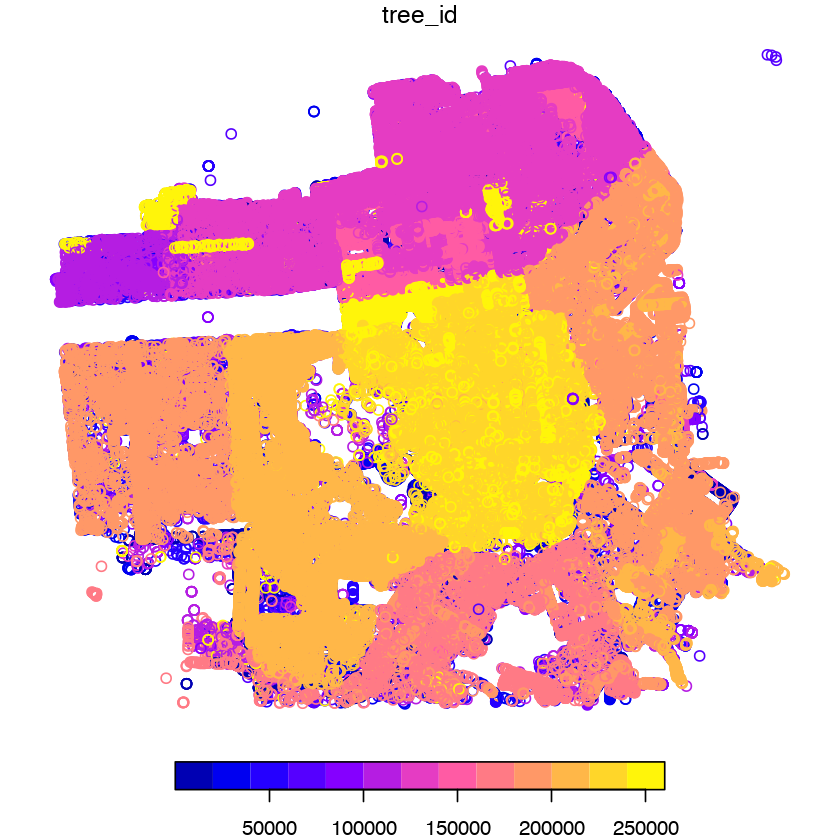

In [6]:
plot(trees_tidy_sf)

Next, let's make a heatmap of tree density in San Francisco. The goal of this map is to show the "greenest" streets of San Francisco.

To do this, we'll install and load the "spatialEco" package that has a handy KDE function.

Warning message:
“package ‘raster’ was built under R version 3.4.4”Loading required package: sp
Warning message:
“package ‘sp’ was built under R version 3.4.4”
Attaching package: ‘raster’

The following object is masked from ‘package:dplyr’:

    select




 calculating unweighted kde 


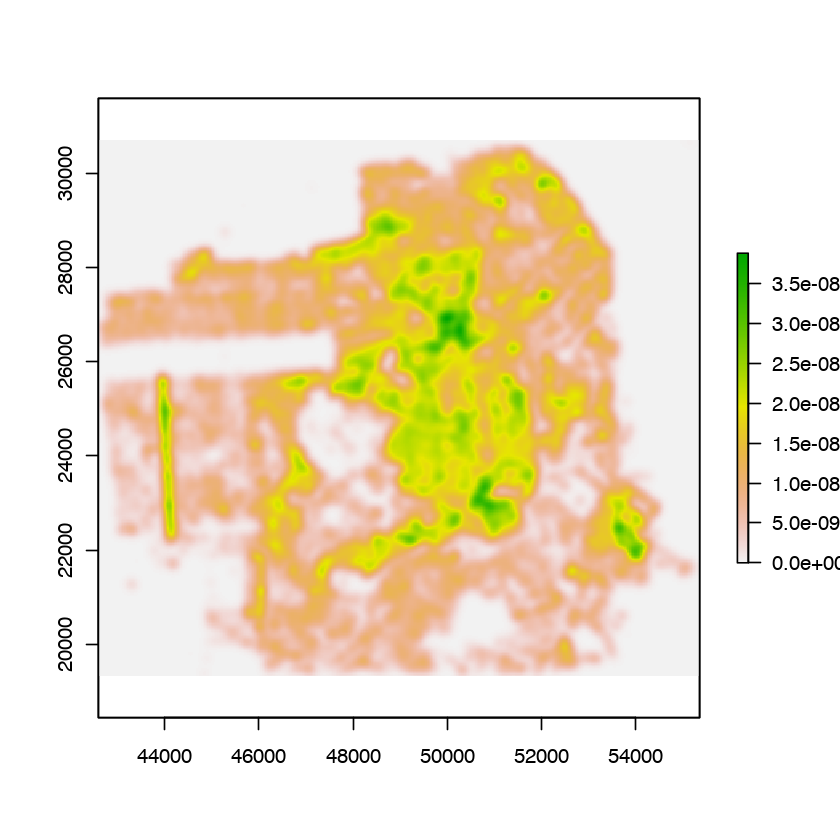

In [8]:
library(spatialEco)
library(raster)

trees_tidy_kde = trees_tidy_sf %>%
        as('Spatial') %>% # sp.kde() requires an sp object as input
        sp.kde(bw = 400, n = 750, standardize = FALSE) # This function may take several minutes to run.


plot(trees_tidy_kde)

To make our map look "nicer", we can use the "leaflet" package to place a basemap under our KDE raster layer. 

HTML widgets cannot be represented in plain text (need html)
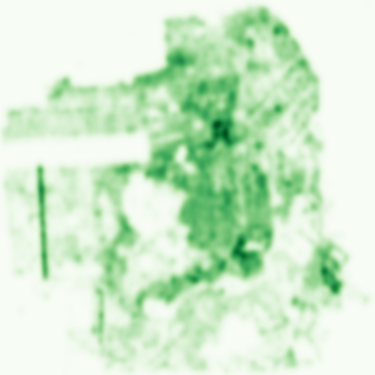

In [10]:
library(leaflet)

kde_map = leaflet() %>%
        addTiles() %>%
        addRasterImage(trees_tidy_kde, color = "Greens", opacity = .65)

kde_map

And there you have it!

## Challenge
* Explore the "leaflet" documentation further and add an appropriate legend to the map
* Import a shapefile of San Francisco's city boundaries from a static link or API into R. Then, crop the KDE raster, "trees_tidy_kde", to the shapefile.